In [1]:
import torch
import os


In [2]:
# large model
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dinov2_vitb14

Using cache found in /work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/work/gz2wang/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [3]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

Using cuda!
Processing video...


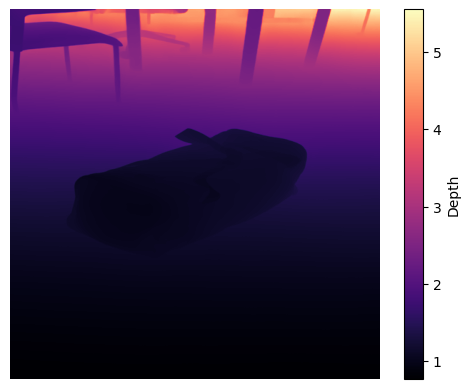

Finished processing frame 0
Finished processing frame 1
Finished processing frame 2
Finished processing frame 3
Finished processing frame 4
Finished processing frame 5
Finished processing frame 6
Finished processing frame 7
Finished processing frame 8
Finished processing frame 9
Finished processing frame 10
Finished processing frame 11
Finished processing frame 12
Finished processing frame 13
Finished processing frame 14
Finished processing frame 15
Finished processing frame 16
Finished processing frame 17
Finished processing frame 18
Finished processing frame 19
Finished processing frame 20
Finished processing frame 21
Finished processing frame 22
Finished processing frame 23
Finished processing frame 24
Finished processing frame 25
Finished processing frame 26
Finished processing frame 27
Finished processing frame 28
Finished processing frame 29
Finished processing frame 30
Finished processing frame 31
Finished processing frame 32
Finished processing frame 33
Finished processing fram

In [5]:
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
import numpy as np

patch_size = dinov2_vitb14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14


processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")


if torch.cuda.is_available():
  print('Using cuda!')
  device = torch.device("cuda")
  torch.cuda.empty_cache()
  dinov2_vitb14 = dinov2_vitb14.to(device)
  model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)
else:
  device = torch.device("cpu")

total_features  = []

total_depth_features = []

video_path = "duffelbag.mp4"

cap = cv2.VideoCapture(video_path)

frame_number = 0

print("Processing video...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.transpose(Image.ROTATE_270) 

    img_t = transform1(img)

    #DINOV2
    features_dict = dinov2_vitb14.forward_features(img_t.unsqueeze(0).to(device))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features.detach().cpu())


    #DEPTH PRO
    if frame_number % 5 == 0:

        inputs = processor(images=frame, return_tensors="pt").to(device)
        # Run inference
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Process the depth map
        depth_map = processor.post_process_depth_estimation(outputs, target_sizes=[(frame.shape[0], frame.shape[1])])[0]
        
        # Convert depth map to an image
        depth_tensor = depth_map["predicted_depth"]  # Extract depth tensor
        depth_array = depth_tensor.squeeze().cpu().numpy()  # Convert to NumPy array

        depth_pil = Image.fromarray(depth_array)
        depth_pil = depth_pil.transpose(Image.ROTATE_270)  # Rotate to match DINOv2 output
        depth_pil = depth_pil.resize((520, 520))  # Resize
        depth_pil = depth_pil.crop((1, 1, 519, 519))  # Center crop

        # Convert depth to tensor and normalize
        depth_transformed = transforms.ToTensor()(depth_pil).squeeze()
    
        total_depth_features.append(depth_transformed.numpy())
    else:
        total_depth_features.append(total_depth_features[-1])

    
    if frame_number == 0:
        plt.imshow(depth_transformed.numpy(), cmap="magma")  # Use 'magma' colormap for better depth visualization
        plt.axis("off")  # Remove axes
        plt.colorbar(label="Depth")
        plt.show()

    print("Finished processing frame", frame_number)

    frame_number+=1

cap.release() 

print("Finished processing video!")
total_features = torch.cat(total_features, dim=0)
print("total features", total_features.shape)
print("total depth features", len(total_depth_features))

num_frames = total_features.shape[0]
print('num frames:', num_frames)

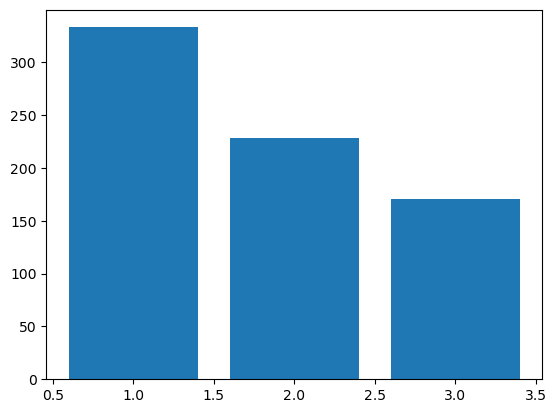

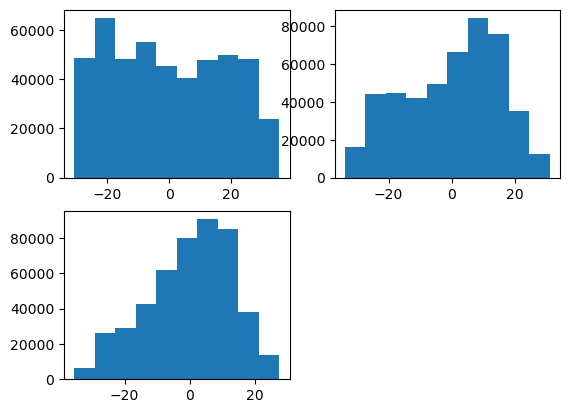

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(num_frames * patch_h * patch_w, feat_dim).cpu() #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)


plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.show()

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

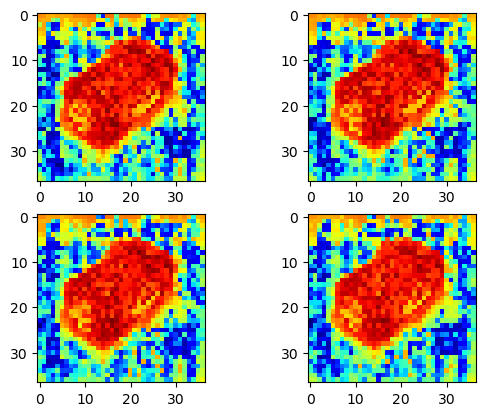

In [7]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w), cmap="jet")

plt.show()

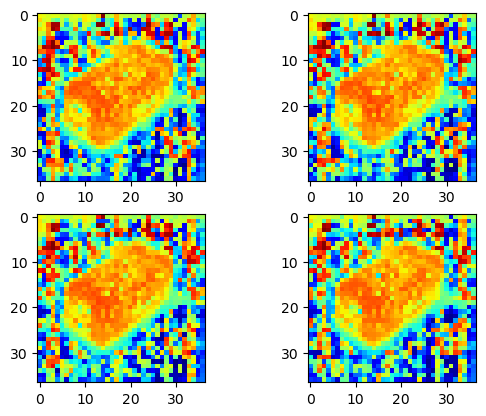

In [8]:
# min_max scale
pca_features_2nd = (pca_features[:, 1] - pca_features[:, 1].min()) / \
                     (pca_features[:, 1].max() - pca_features[:, 1].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_2nd[i*patch_h*patch_w : (i+1)*patch_h*patch_w].reshape(patch_h, patch_w), cmap="jet")

plt.show()

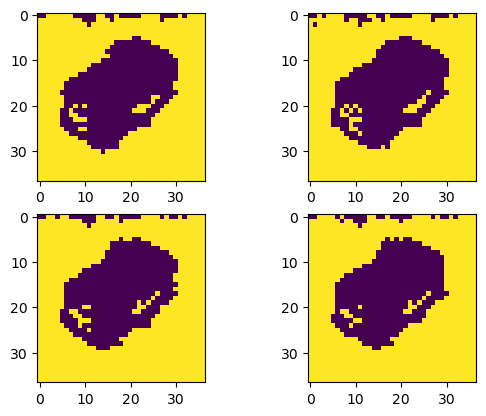

In [9]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = ~((pca_features[:, 0] >= 0.7) & (pca_features[:, 0] <= 1))  # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[(i) * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


(345, 37, 37, 3)


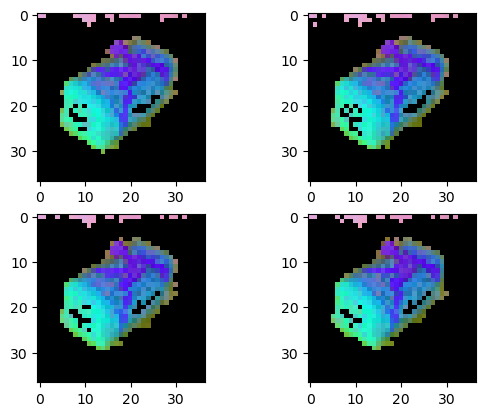

In [10]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg])
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format

pca_features_rgb = pca_features_rgb.reshape(num_frames, patch_h, patch_w, 3)
print(pca_features_rgb.shape)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

# Bounding Box

In [11]:

def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)


# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[3]

if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv2.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow.create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN.create()
else:
    tracker = cv2.legacy.TrackerMOSSE.create()

In [12]:
import numpy as np
# Read video
video = cv2.VideoCapture(video_path)
ok, frame = video.read()

img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
img = img.transpose(Image.ROTATE_270) 
img_t = transform1(img)

img_np = img_t.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
img_np = (img_np * 0.2 + 0.5) * 255  # Reverse normalization
frame_transformed = np.clip(img_np, 0, 255).astype(np.uint8)  # Clip and convert to uint8

    
# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# video_output_file_name = 'bottle' + tracker_type + ".mp4"
# video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 30, (width, height))

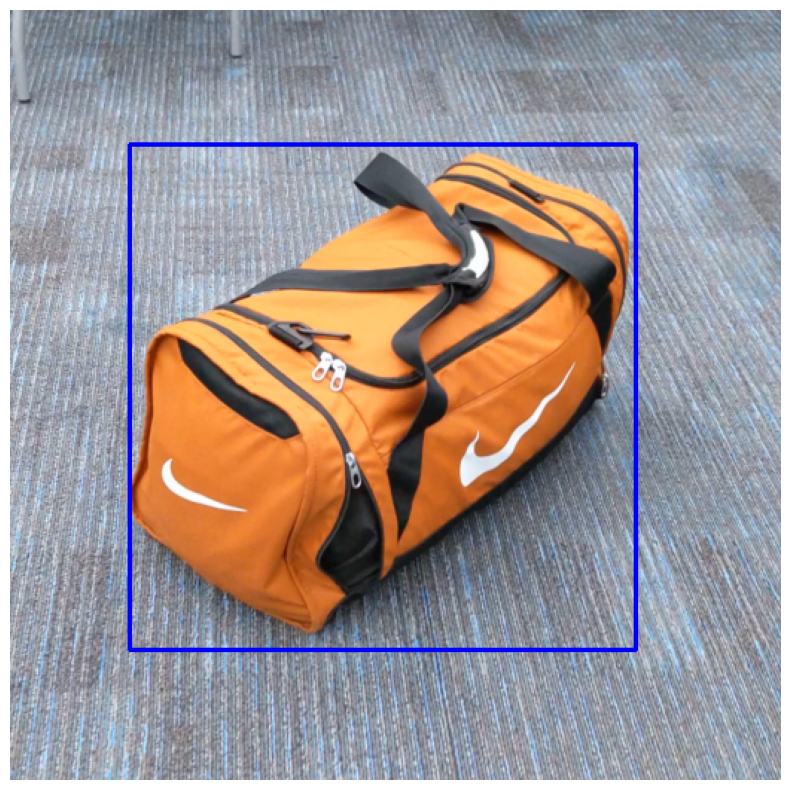

In [14]:
# Define a bounding box
bbox = (80, 90, 340, 340)
# bbox = cv2.selectROI(frame_transformed, False)
# print(bbox)
displayRectangle(frame_transformed, bbox)

In [15]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame_transformed, bbox)

In [16]:
bounding_boxes = [bbox]
frame_num = 1

#clear output dir
!rm outputBounding/*

while True:
    ok, frame = video.read()

    if not ok:
        break

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = img.transpose(Image.ROTATE_270) 
    img_t = transform1(img)

    img_np = img_t.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
    img_np = (img_np * 0.2 + 0.5) * 255  # Reverse normalization
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)  # Clip and convert to uint8
    frame_transformed = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  # Convert back to BGR




    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame_transformed)

    prev_bbox = bounding_boxes[-1]
    if abs(prev_bbox[0] - bbox[0]) > 50 or abs(prev_bbox[1] - bbox[1]) > 50:
        bbox = prev_bbox

    bounding_boxes.append(bbox)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame_transformed, bbox)
    else:
        drawText(frame_transformed, "Tracking failure detected", (80, 140), (0, 0, 255))
    pic = Image.fromarray(frame_transformed)
    pic.save('outputBounding/output{}.png'.format(frame_num))
    frame_num+=1

    # # Display Info
    # drawText(frame_transformed, tracker_type + " Tracker", (80, 60))
    # drawText(frame_transformed, "FPS : " + str(int(fps)), (80, 100))

    # # Write frame to video
    # video_out.write(frame_transformed)

video.release()
# video_out.release()
print(len(bounding_boxes))

345


In [45]:
print(bounding_boxes[1])

(119, 5, 220, 370)


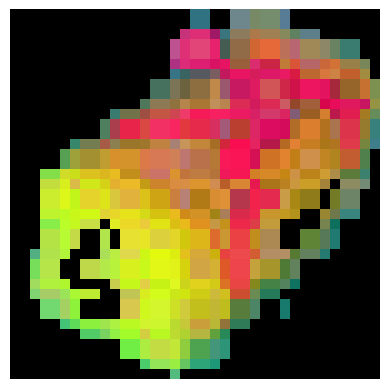

finished
color diff 345 [0.0, 1.5426571159390396, 1.2963873523089464, 1.5209802196301911, 2.938812885957389]
color var diff 345 [0.0, 1.5426571159390396, 1.2963873523089464, 1.5209802196301911, 2.938812885957389]
item depths 345 [1.0683159, 1.0697513, 1.0715052, 1.0705322, 1.0686873]
centers 0 []


In [17]:
from matplotlib import cm
import numpy as np
from base64 import b64encode
from IPython.display import HTML

#clear output dir
!rm outputPNGS/*

def rescale_bbox(old_bbox, original_size=518, new_size=40):
    """
    Rescales a bounding box from an original image size to a new image size.

    Parameters:
        old_bbox (tuple): (x, y, width, height) of the bounding box in the original image.
        original_size (int): The size of the original image (default is 518).
        new_size (int): The size of the new image.

    Returns:
        tuple: (new_x, new_y, new_width, new_height) in the new image size.
    """
    scale = new_size / original_size
    new_bbox = tuple(int(coord * scale) for coord in old_bbox)
    return new_bbox

def filter_color(image, lower_bound, upper_bound):
    """
    Filters an image to keep only pixels within the given HSV color bounds.

    Args:
        image (numpy.ndarray): The input image in RGB format.
        lower_bound (tuple): The lower HSV bound (h_min, s_min, v_min).
        upper_bound (tuple): The upper HSV bound (h_max, s_max, v_max).

    Returns:
        numpy.ndarray: The masked image where only the specified color remains.
    """
    # Convert RGB to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Create a binary mask for pixels within the range
    mask = cv2.inRange(hsv_image, np.array(lower_bound), np.array(upper_bound))

    # Apply the mask to keep only the specified color
    filtered_image = cv2.bitwise_and(image, image, mask=mask)

    return filtered_image, mask

def keep_largest_component(mask):
    """
    Keeps only the largest connected component in a binary mask.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Find the largest component (excluding background label 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # +1 to skip background

    # Create a new mask with only the largest component
    largest_mask = (labels == largest_label).astype(np.uint8) * 255

    return largest_mask

def crop_to_mask(image, mask, output_size=100):
    """
    Crops the image to the bounding box of the mask and resizes it to a fixed size.
    """
    # Find bounding box of the mask
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return np.zeros((output_size, output_size, 3), dtype=np.uint8)
        
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    width = max(x_max-x_min, y_max-y_min, 10)

    # Crop the image
    cropped_image = image[y_min:y_min+width+1, x_min:x_min+width+1]

    
    resized_image = cv2.resize(cropped_image, (output_size, output_size), interpolation=cv2.INTER_NEAREST)
    return resized_image

def crop_to_box(image, bbox, output_size=100):
    width = max(bbox[2], bbox[3], 10)
    half_width = width//2

    center_x = bbox[0] + bbox[2]//2
    center_y = bbox[1] + bbox[3]//2
    
    cropped_image = image[max(center_y-half_width, 0): center_y+half_width+1, max(center_x-half_width, 0): center_x+half_width+1]

    if cropped_image is None or cropped_image.size == 0:
        print(bbox)
        print("ERROR")

    resized_image = cv2.resize(cropped_image, (output_size, output_size), interpolation=cv2.INTER_NEAREST)
    return resized_image


def find_avg_color(image):
    # Create a mask where pixels are not black
    mask = np.any(image > [0, 0, 0], axis=-1)
    
    # Get non-black pixels
    non_black_pixels = image[mask]
    
    # Compute the mean color
    average_color = np.mean(non_black_pixels, axis=0)

    return average_color

def find_var_color(image):
    # Create a mask where pixels are not black
    mask = np.any(image > [0, 0, 0], axis=-1)
    
    # Get non-black pixels
    non_black_pixels = image[mask]

    pixels = non_black_pixels.reshape(-1, 3)

    color_variance = np.var(pixels, axis=0)

    return np.mean(color_variance)
    

def l2_distance(triple1, triple2):
    triple1 = np.array(triple1)
    triple2 = np.array(triple2)
    return np.linalg.norm(triple1 - triple2)

def get_depth_in_box(i, bbox):
    the_max = total_depth_features[i].max()
    the_min = total_depth_features[i].min()
    
    width = max(bbox[2], bbox[3], 10)
    half_width = width//2

    center_x = bbox[0] + bbox[2]//2
    center_y = bbox[1] + bbox[3]//2

    # area = total_depth_features[i][center_y-2:center_y+2, center_x-2:center_x+2]

    # for j in range(-50, 50):
    #     for k in range(-50, 50):
    #         total_depth_features[i][center_y+j][center_x+k] = 8

    # depth = area.max()

    depth = total_depth_features[i][center_y][center_x]
    # total_depth_features[i][center_y][center_x] = 5
    # return (depth-the_min)/(the_max-the_min)
    return depth
    

#HSV values
lower_brown = (100, 50, 50)   # Lower bound for brown
upper_brown = (200, 255, 255) # Upper bound for brown

color_l2_diffs = []
item_depths = []
var_l2_diffs = []

centers = []

prev_color = (0, 0, 0)
prev_var = 0

for i in range(num_frames):
    feature_map = pca_features_rgb[i]
    # feature_map = cm.jet((feature_map - feature_map.min()) / (feature_map.max() - feature_map.min()))[:, :, :3]
    feature_map = (feature_map * 255).astype(np.uint8)
    frame = cv2.cvtColor(feature_map, cv2.COLOR_RGB2BGR)

    size = frame.shape[0]
    # print(size)

    new_bbox = rescale_bbox(bounding_boxes[i], 518, size)

    new_frame = crop_to_box(frame, new_bbox, size)

    # new_frame, _ = filter_color(new_frame, lower_brown, upper_brown)

    avg_color = find_avg_color(new_frame)

    color_var = find_var_color(new_frame)

    color_var_diff = l2_distance(color_var, prev_var)

    if i == 0:
        prev_color = avg_color
    color_diff = l2_distance(avg_color, prev_color)


    color_l2_diffs.append(color_diff)
    var_l2_diffs.append(color_var_diff)

    item_depth = get_depth_in_box(i, bounding_boxes[i])

    # centers.append((x, y))

    item_depths.append(item_depth)

    prev_var = color_var

    # filtered_frame, mask = filter_color(frame, lower_brown, upper_brown)

    # gray = cv2.cvtColor(filtered_frame, cv2.COLOR_RGB2GRAY)

    # _, gray_bin_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    # component_mask = keep_largest_component(gray_bin_mask)

    # try:
    #     filtered_frame = crop_to_mask(frame, component_mask, size)
    # except:
    #     print("ERROR OCCURED")
    #     plt.imshow(component_mask)
    #     plt.axis("off")  # Hide axes
    #     plt.show()

    if i == 300:
        
        plt.imshow(new_frame)
        plt.axis("off")  # Hide axes
        plt.show()

        # plt.imshow(gray_bin_mask)
        # plt.axis("off")  # Hide axes
        # plt.show()

        # plt.imshow(component_mask)
        # plt.axis("off")  # Hide axes
        # plt.show()
        

        
    pic = Image.fromarray(new_frame)
    pic.save('outputPNGS/output{}.png'.format(i))

cv2.destroyAllWindows()
print('finished')

print("color diff", len(color_l2_diffs), color_l2_diffs[0:5])
print("color var diff", len(var_l2_diffs), color_l2_diffs[0:5])
print("item depths", len(item_depths), item_depths[0:5])
print("centers", len(centers), centers[0:5])


In [98]:
combined_arr = np.vstack((color_l2_diffs, item_depths))

np.savetxt("pasta_sauce_data.csv", combined_arr, delimiter=",", fmt="%.4f")

In [45]:
print(item_depths[-1])

0.77081573


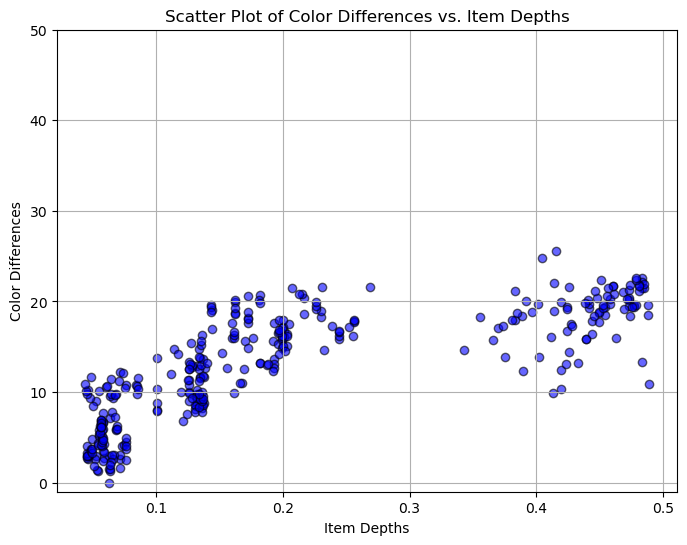

In [79]:


plt.figure(figsize=(8, 6))  # Set figure size
plt.scatter(item_depths, color_l2_diffs, color='b', alpha=0.6, edgecolors='k')  # Scatter plot
plt.xlabel("Item Depths")
plt.ylabel("Color Differences")
plt.title("Scatter Plot of Color Differences vs. Item Depths")
plt.grid(True)  # Show grid for better readability
plt.ylim((-1,50))
plt.show()

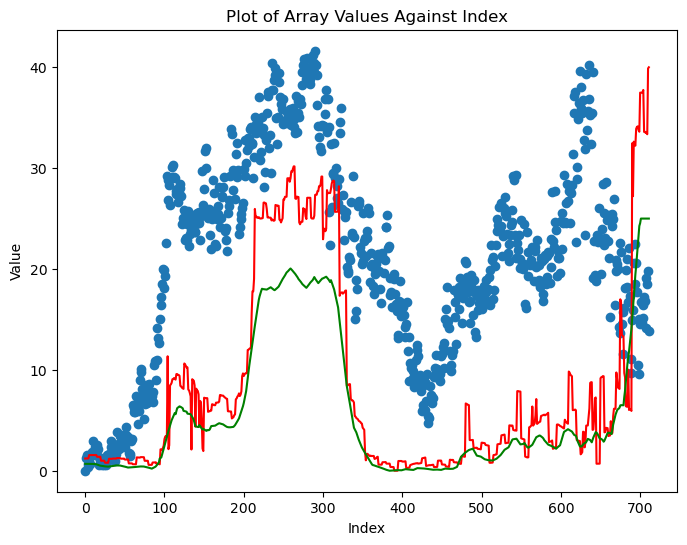

In [97]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def moving_average_same_length(data, window_size=5):
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    pad_left = (window_size - 1) // 2
    pad_right = window_size - 1 - pad_left
    return np.pad(smoothed, (pad_left, pad_right), mode='edge')


item_depths_smooth = moving_average_same_length(item_depths, window_size=20)

plt.figure(figsize=(8,6))
plt.scatter(range(len(color_l2_diffs)), color_l2_diffs)
item_depths = np.array(item_depths) 
plt.plot(range(len(item_depths)), (item_depths-min(item_depths))*40/(max(item_depths)-min(item_depths)), linestyle='-', color='r')
plt.plot(range(len(item_depths_smooth)), (item_depths_smooth-min(item_depths_smooth))*25/(max(item_depths_smooth)-min(item_depths_smooth)), linestyle='-', color='g')

# plt.plot(range(len(item_depths)), item_depths, linestyle='-', color='r')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Plot of Array Values Against Index")
plt.show()

1.803655
3.8434095


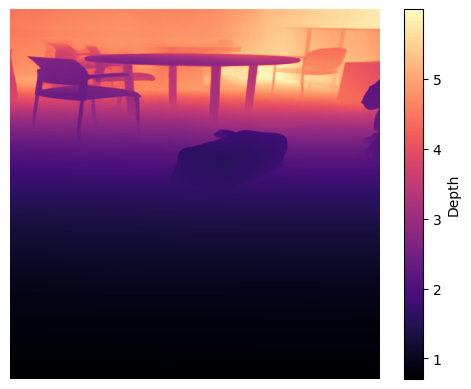

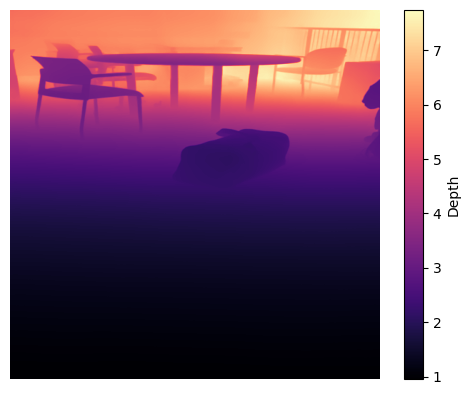

In [74]:
print(item_depths[150])
print(item_depths[155])

plt.imshow(total_depth_features[150], cmap="magma")  # Use 'magma' colormap for better depth visualization
plt.axis("off")  # Remove axes
plt.colorbar(label="Depth")
plt.show()


plt.imshow(total_depth_features[155], cmap="magma")  # Use 'magma' colormap for better depth visualization
plt.axis("off")  # Remove axes
plt.colorbar(label="Depth")
plt.show()

1080 1920
Middle 1.1395534
4.5386877 0.84508723


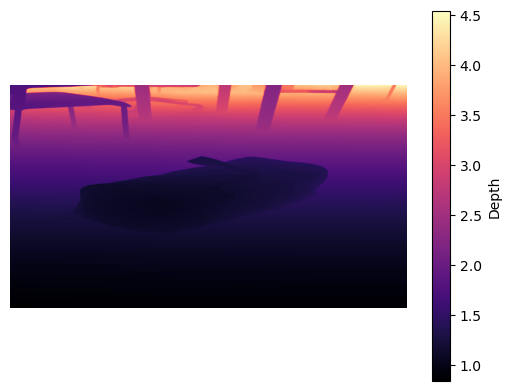

In [15]:
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

# Load and process image
image = Image.open("frame_0.jpg").convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(device)

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Process the depth map
depth_map = processor.post_process_depth_estimation(outputs, target_sizes=[image.size])[0]

# Convert depth map to an image
depth_tensor = depth_map["predicted_depth"]  # Extract depth tensor
depth_array = depth_tensor.squeeze().cpu().numpy()  # Convert to NumPy array

print(len(depth_array), len(depth_array[0]))
print("Middle", depth_array[500][960])
print(depth_array.max(), depth_array.min())

plt.imshow(depth_array, cmap="magma")  # Use 'magma' colormap for better depth visualization
plt.axis("off")  # Remove axes
plt.colorbar(label="Depth")
plt.show()

In [10]:
import cv2

video_path = "duffelbag.mp4"  # Path to your video file
frame_number = 220  # Change to the frame index you want

cap = cv2.VideoCapture(video_path)

# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

if ret:
    rotated_90 = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite("frame_220.jpg", rotated_90)  # Save as an image
    cv2.destroyAllWindows()
else:
    print("Failed to capture frame.")

cap.release()

In [1]:
print("hi")

hi


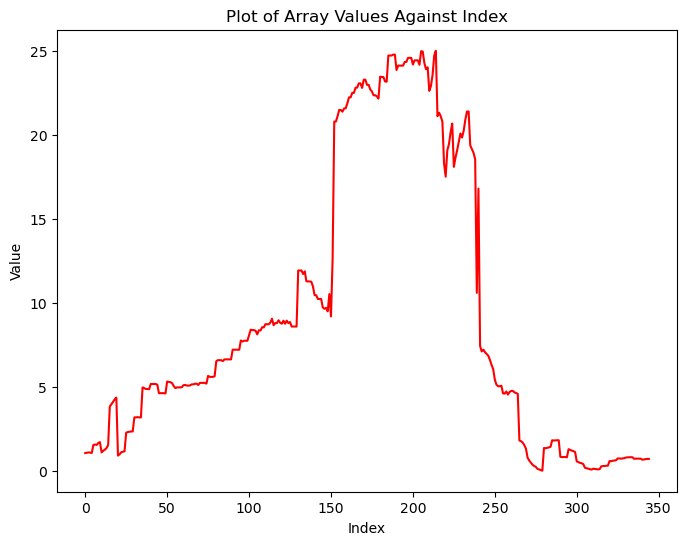

In [6]:
import numpy as np
import matplotlib.pyplot as plt

loaded_arr = np.loadtxt("duffelbag_data.csv", delimiter=",")
data = loaded_arr[1]

plt.figure(figsize=(8,6))
item_depths = np.array(data) 
plt.plot(range(len(item_depths)), (data-min(item_depths))*25/(max(item_depths)-min(item_depths)), linestyle='-', color='r')
# plt.plot(range(len(item_depths_smooth)), (item_depths_smooth-min(item_depths_smooth))*25/(max(item_depths_smooth)-min(item_depths_smooth)), linestyle='-', color='g')

# plt.plot(range(len(item_depths)), item_depths, linestyle='-', color='r')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Plot of Array Values Against Index")
plt.show()
